In [6]:
specific = True

folder_path = "clean_loop/no_mod"
if specific:
    # paths = ["privacy/no_mod_10", "privacy/no_mod_25", "privacy/no_mod_50", "privacy/no_mod_80"]
    paths = ["personalization/no_mod_10", "personalization/no_mod_25", "personalization/no_mod_50", "personalization/no_mod_80"]
# save_path = "privacy/no_mod"
save_path = "personalization/no_mod"

save = True

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors
import re
import numpy as np
from matplotlib.ticker import PercentFormatter

In [8]:
files = [f for f in os.listdir(folder_path) if f.endswith('_metrics.csv')]
dfs = []

for file in files:
    filename = os.path.splitext(file)[0]  # remove .csv
    parts = filename.split('_')
    if len(parts) >= 3:
        algorithm = parts[1]
        dataset = parts[0]
    else:
        continue  # skip if filename doesn't match pattern

    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    df['algorithm'] = algorithm.upper()
    df['dataset'] = dataset

    dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

In [9]:
if specific:
    specific_df = pd.DataFrame()
    for specific_path in paths:
        folder_path = specific_path

        files = [f for f in os.listdir(folder_path) if f.endswith('_metrics.csv')]

        dfs = []

        for file in files:
            filename = os.path.splitext(file)[0]  # remove .csv
            parts = filename.split('_')
            if len(parts) >= 3:
                algorithm = parts[1]
                dataset = parts[0]
            else:
                continue  # skip if filename doesn't match pattern

            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)

            df['algorithm'] = algorithm.upper()
            df['dataset'] = dataset
            dfs.append(df)

        merged_df_ex = pd.concat(dfs, ignore_index=True)

        merged_df_ex['delta'] = merged_df_ex['value'] - merged_df['value']

        merged = merged_df_ex.merge(
            merged_df,
            on=['key', 'algorithm', 'dataset'],
            suffixes=('_ex', '_ref')
        )

        # Obliczenie różnicy
        merged['delta'] = merged['value_ex'] - merged['value_ref']
        merged['percent_delta'] = (merged['delta'] / merged['value_ref'])
        merged['percent_delta'] = merged['percent_delta'].fillna(0)
        merged['percent_delta'] = merged['percent_delta'].replace([np.inf], 1)

        match = re.search(r'\d+', specific_path)
        if match:
            number = int(match.group())
        merged['percent'] = number
        
        specific_df = pd.concat([specific_df, merged], ignore_index=True)
    percent_labels = {
        10: 'low',
        25: 'moderate',
        50: 'medium',
        80: 'high'
    }

    # Apply the mapping
    specific_df['percent'] = specific_df['percent'].map(percent_labels)


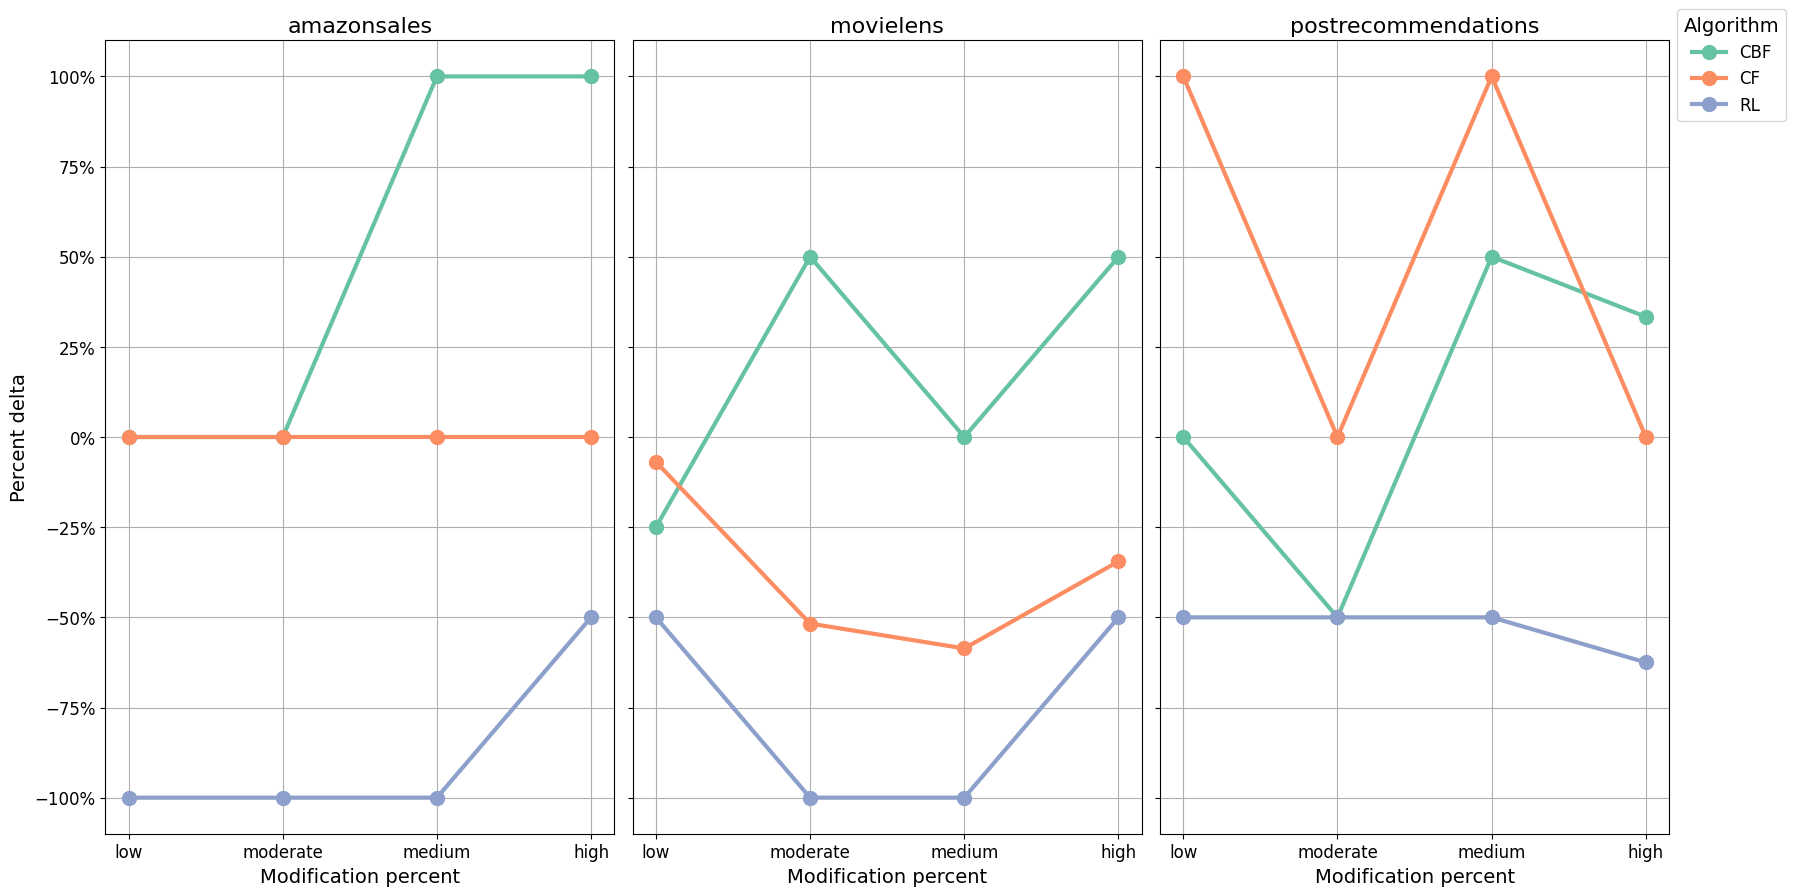

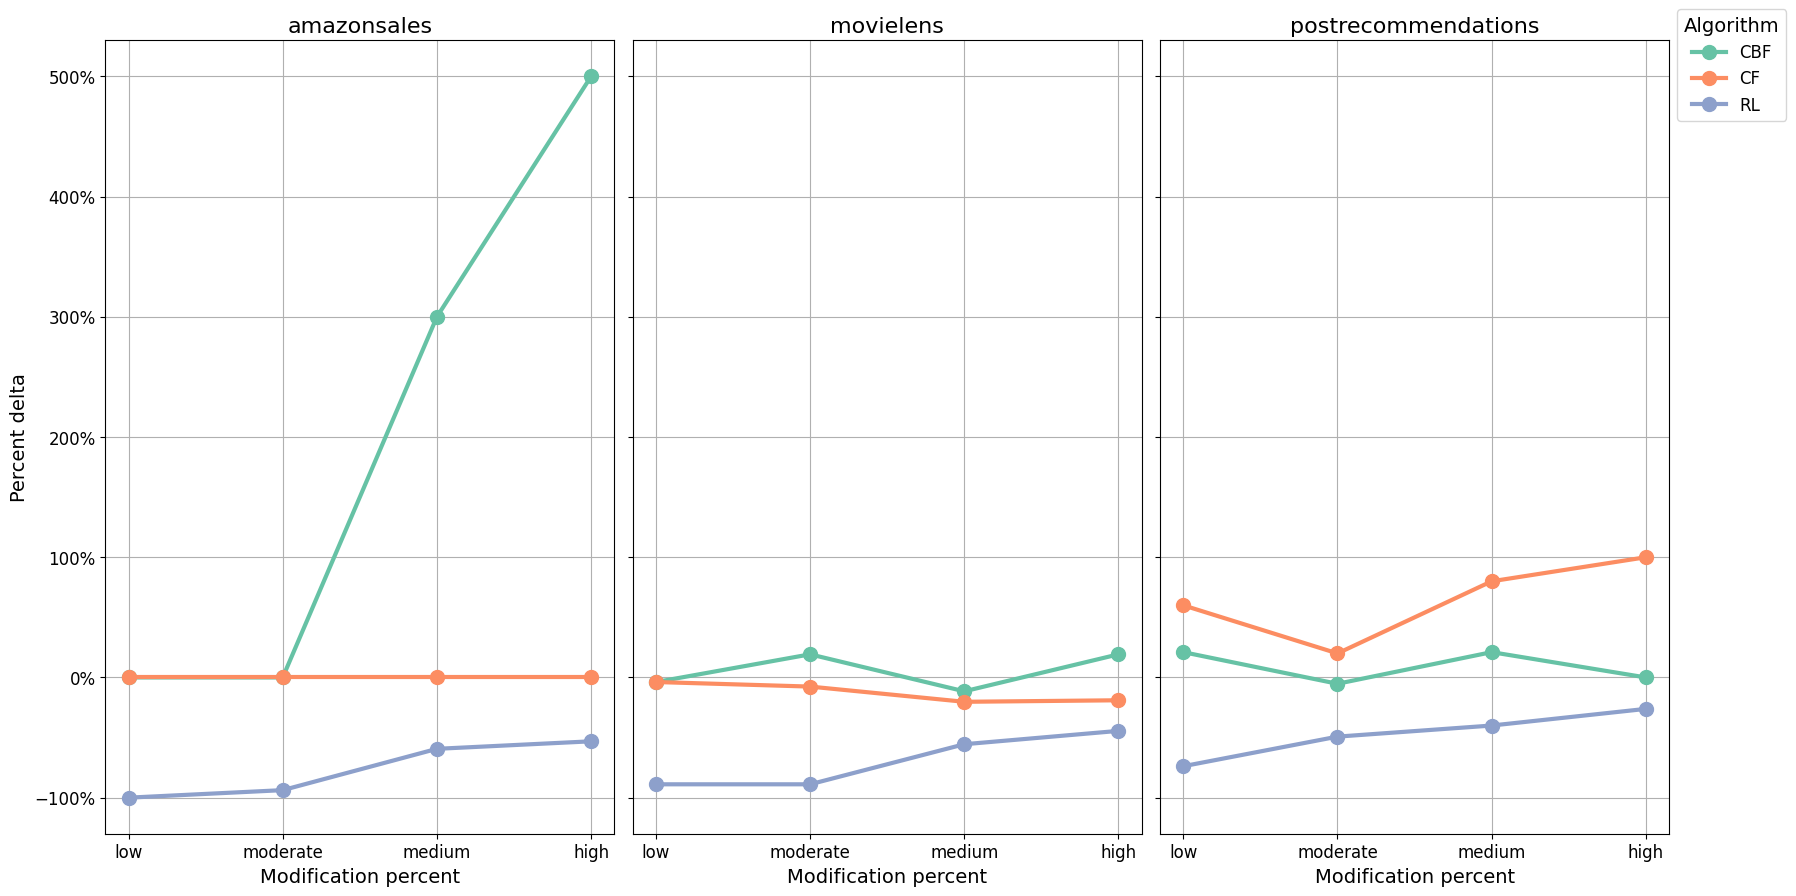

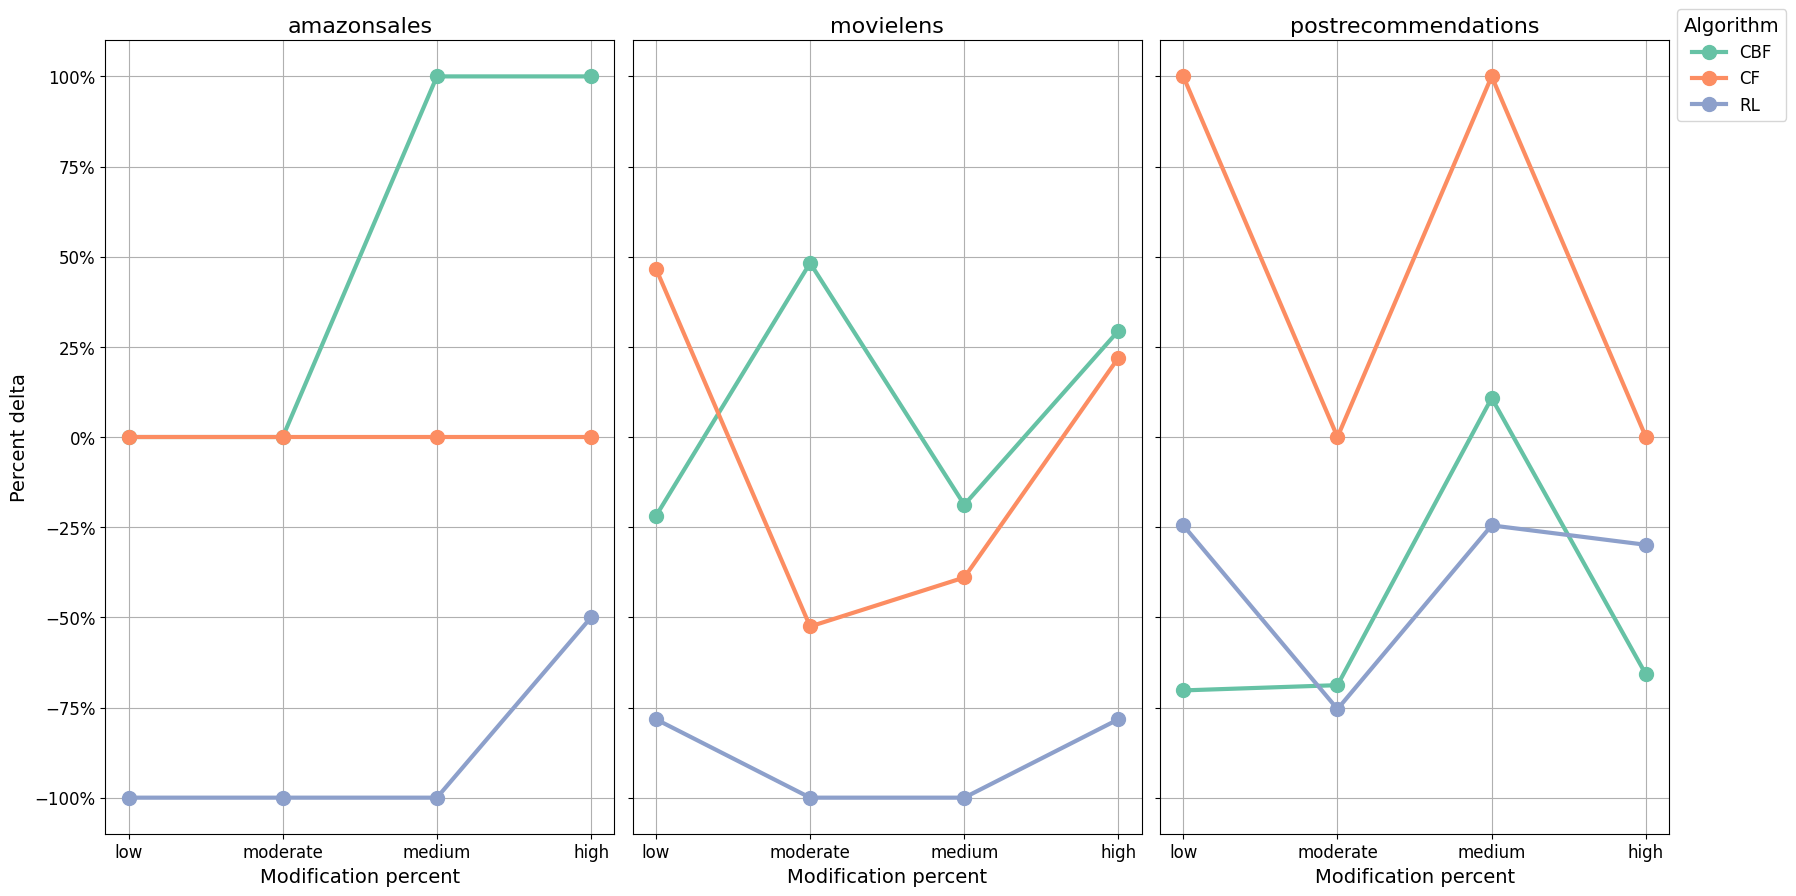

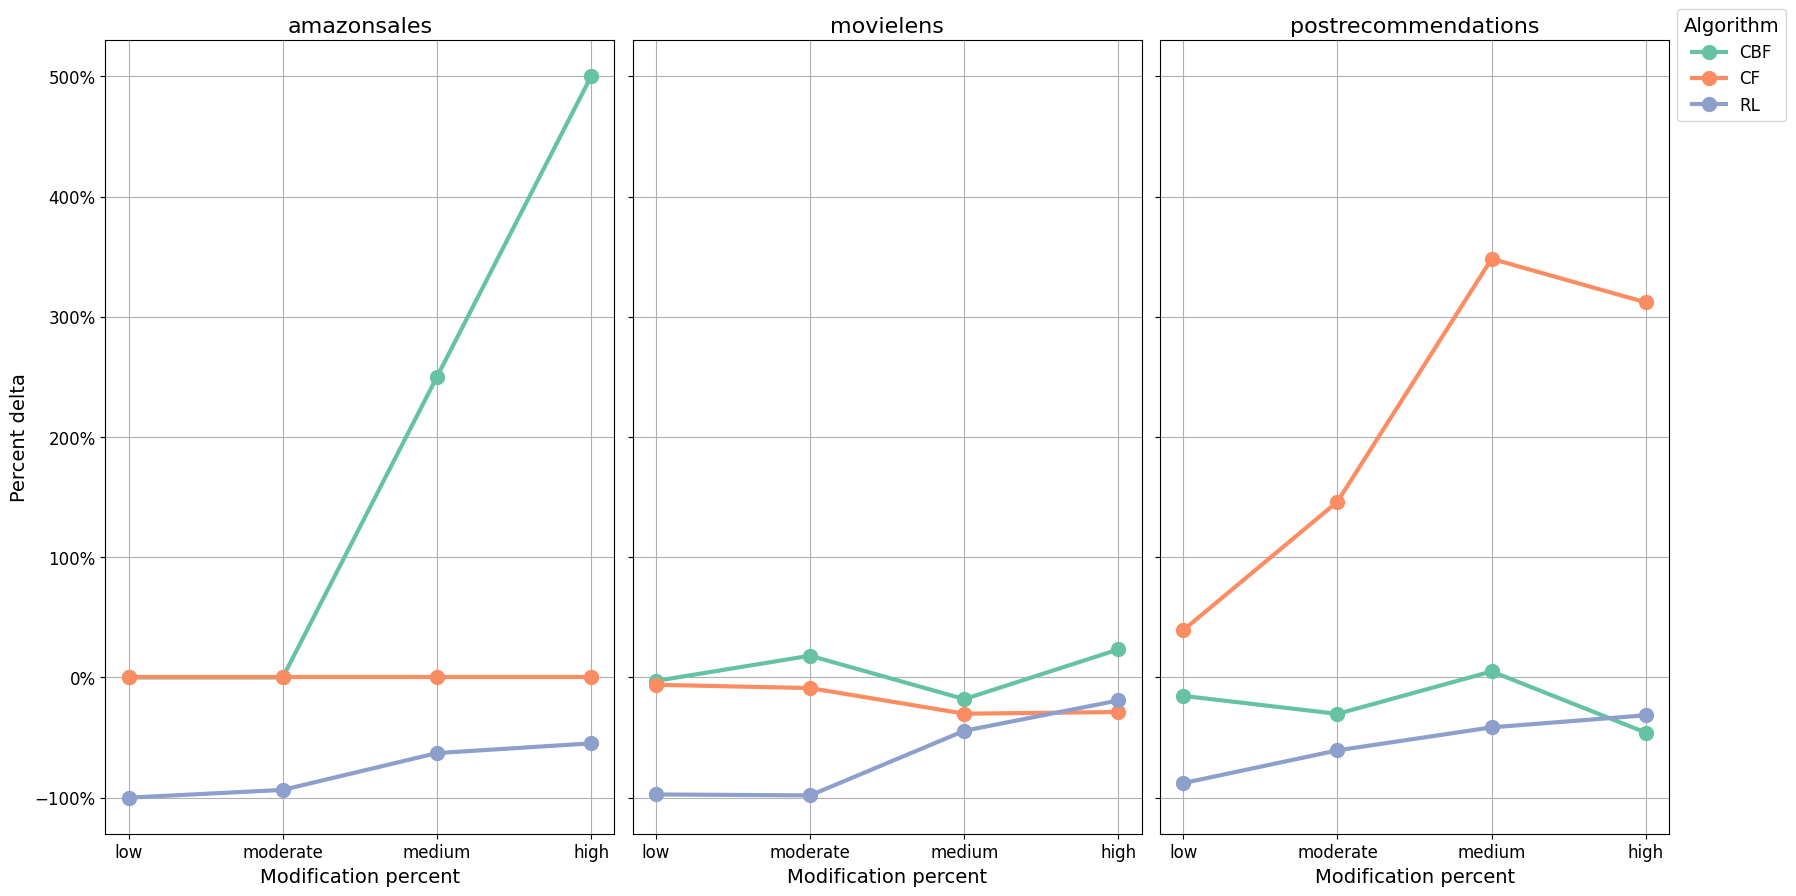

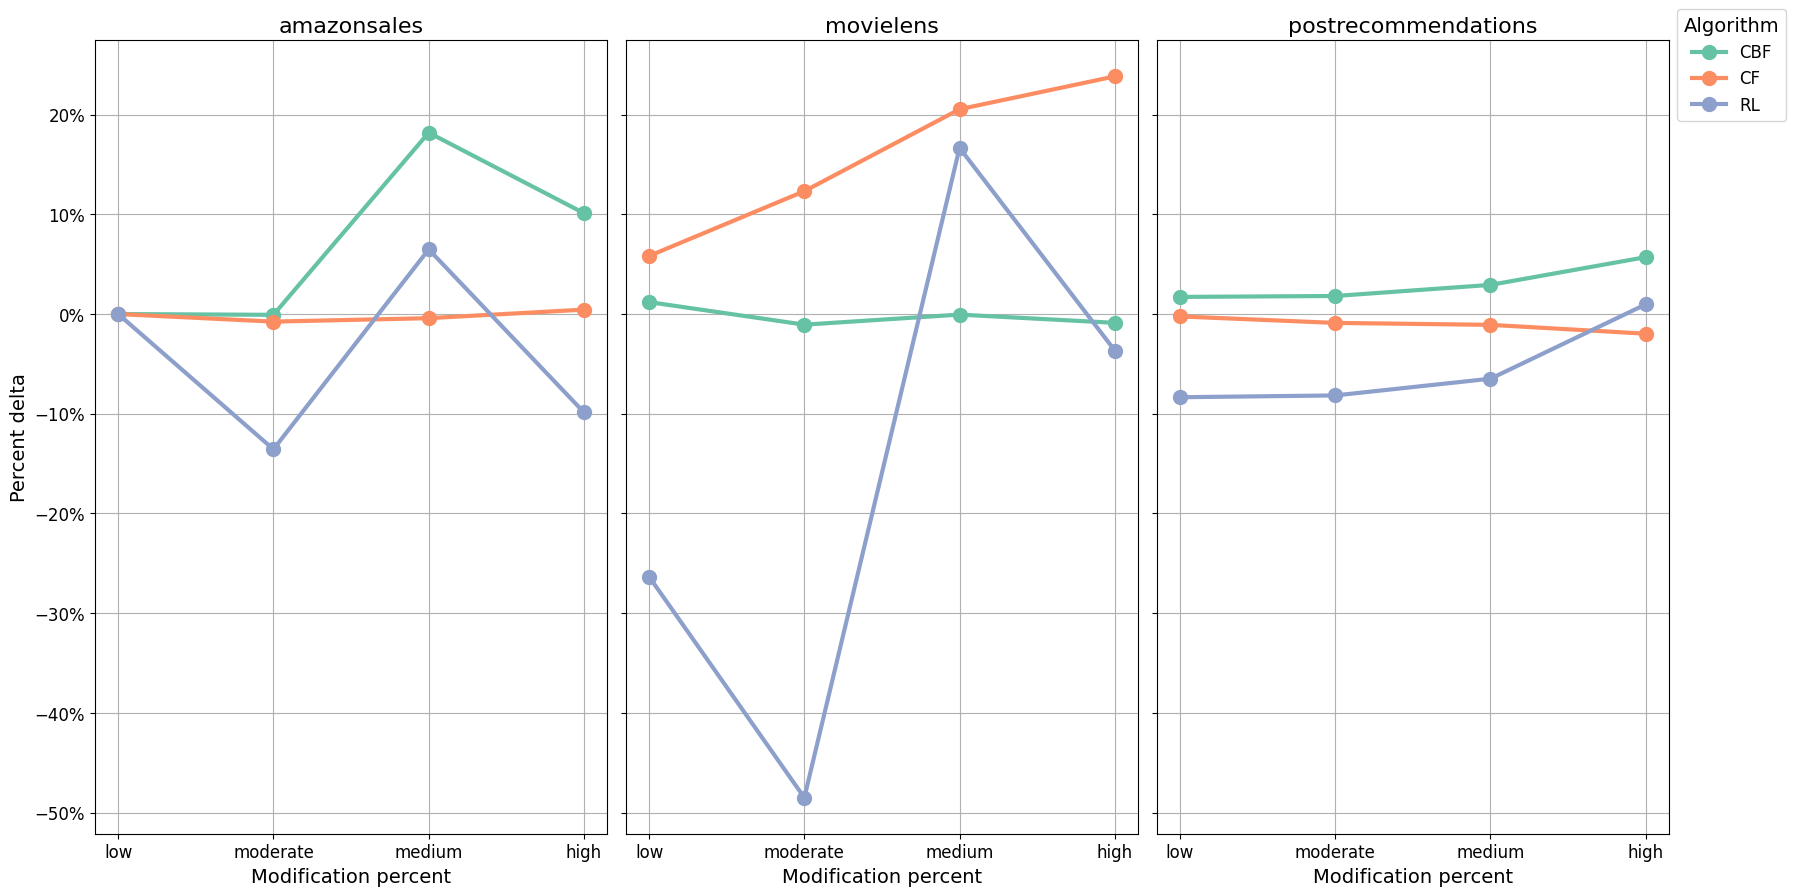

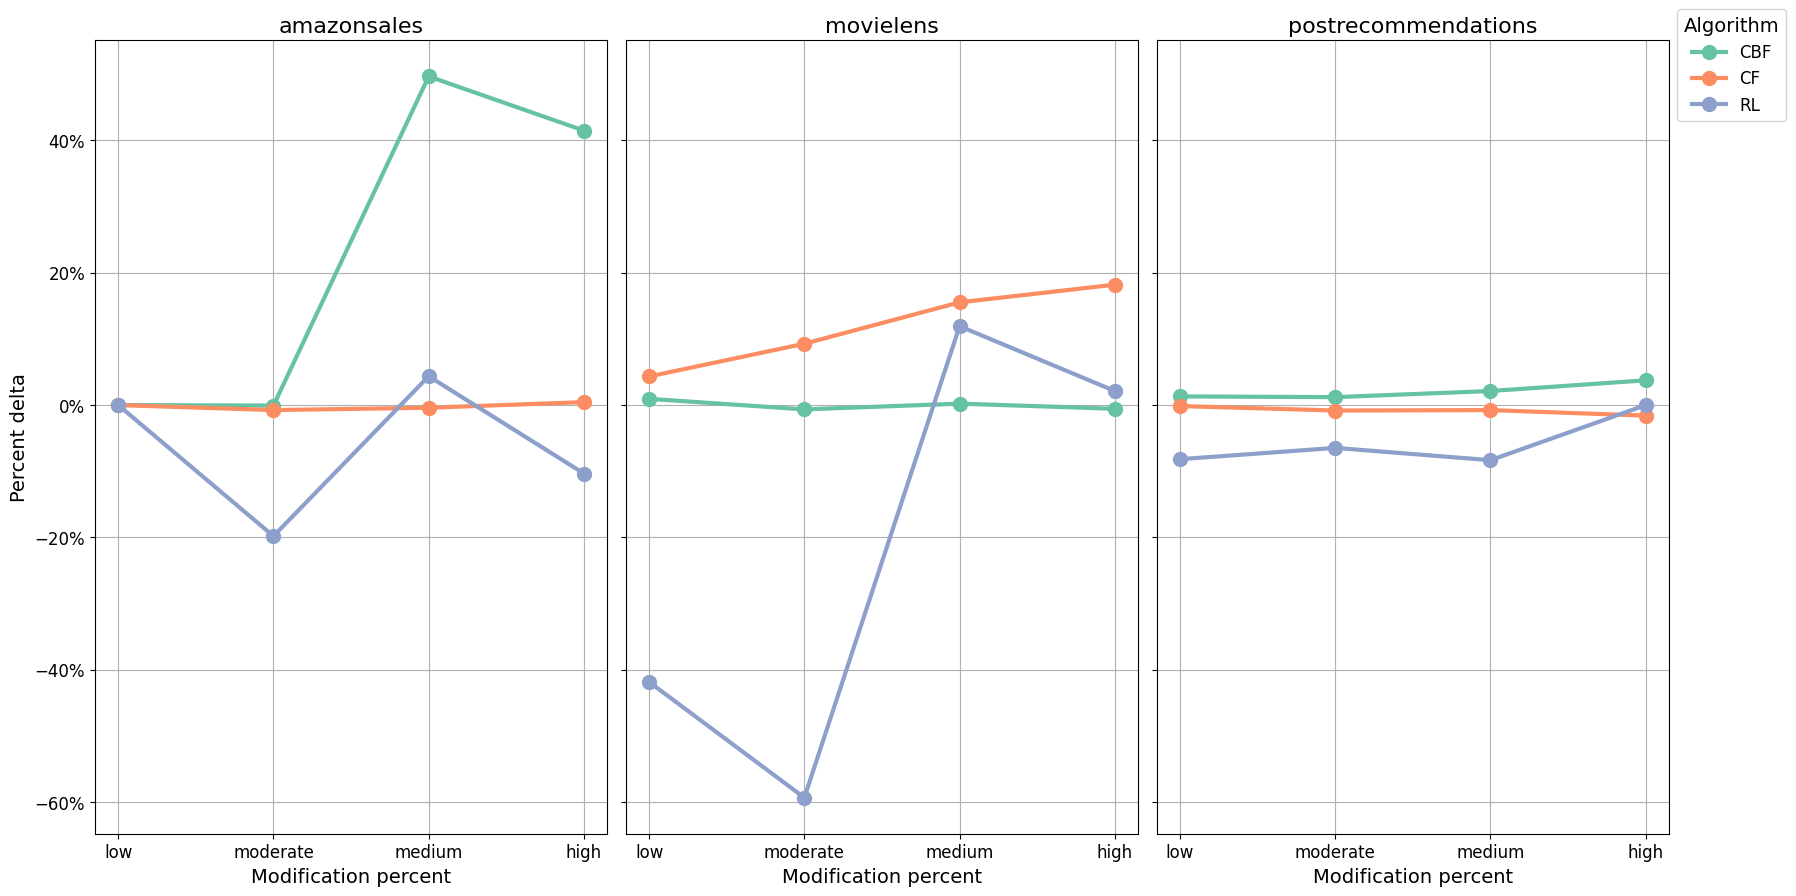

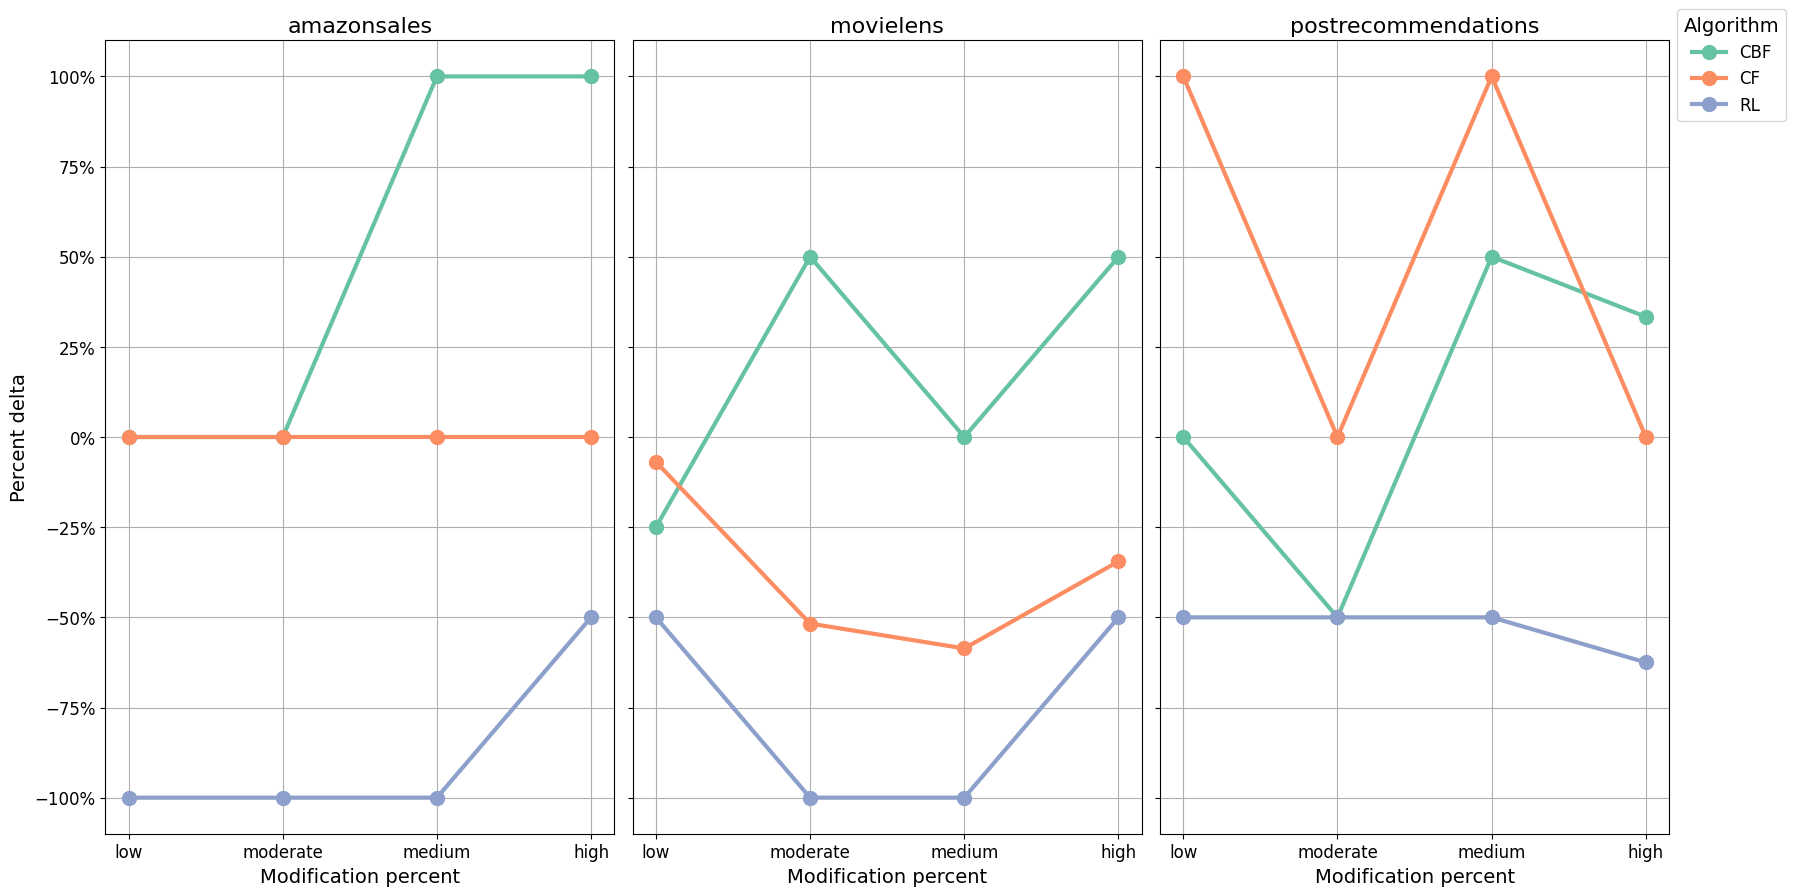

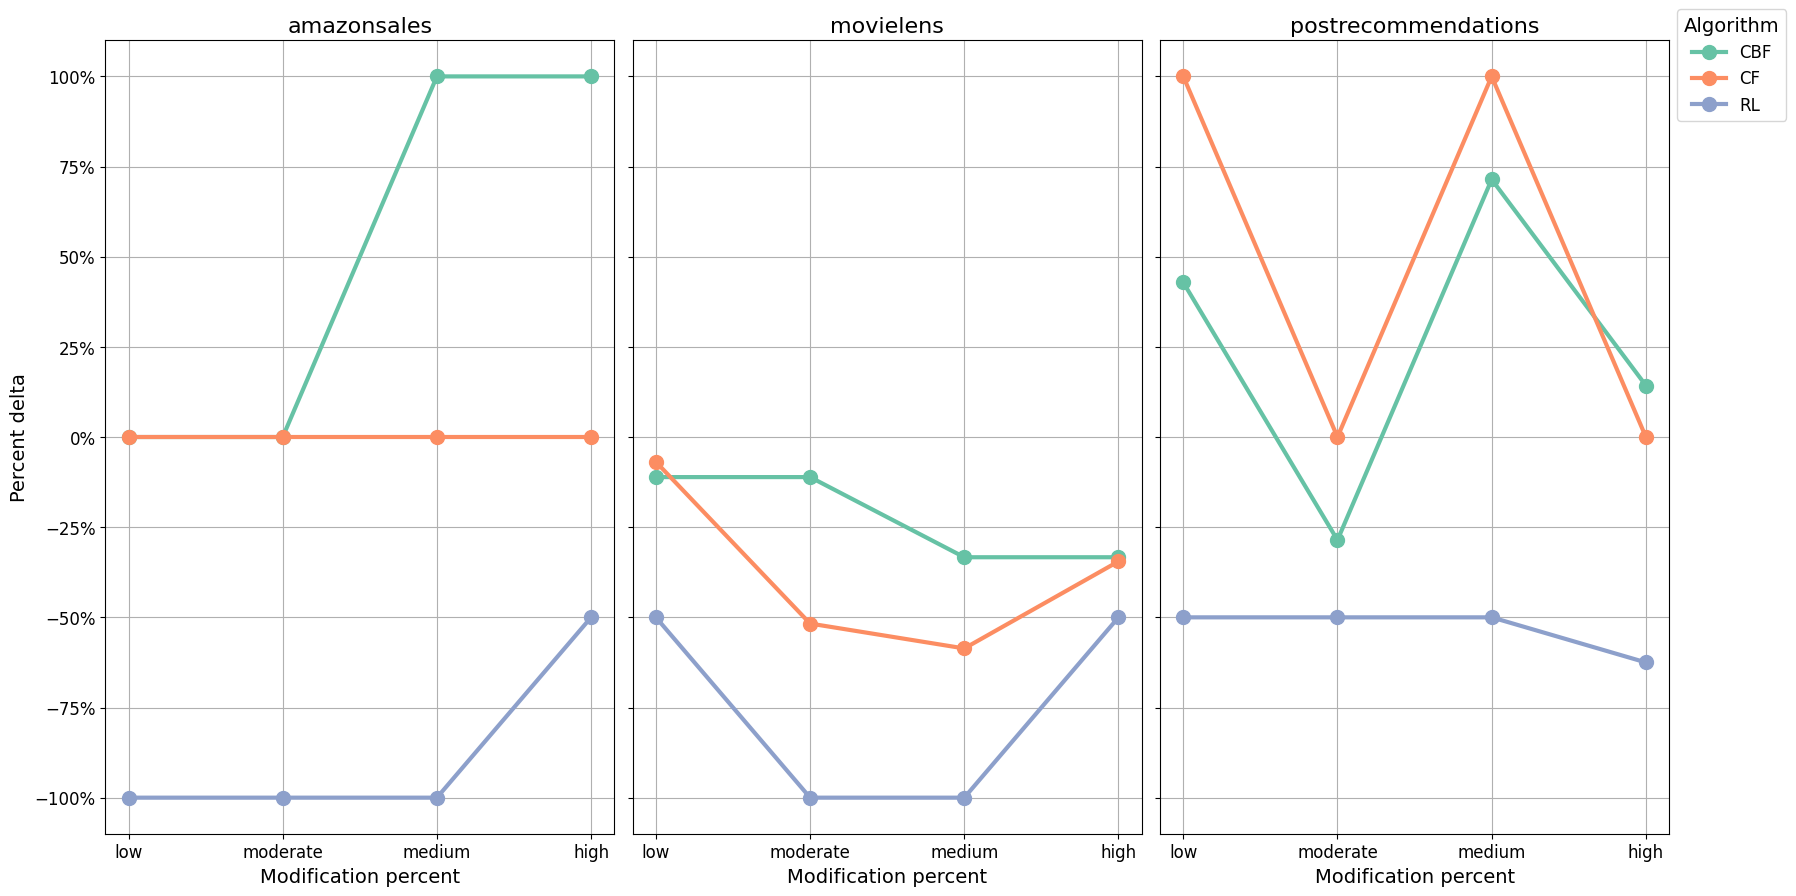

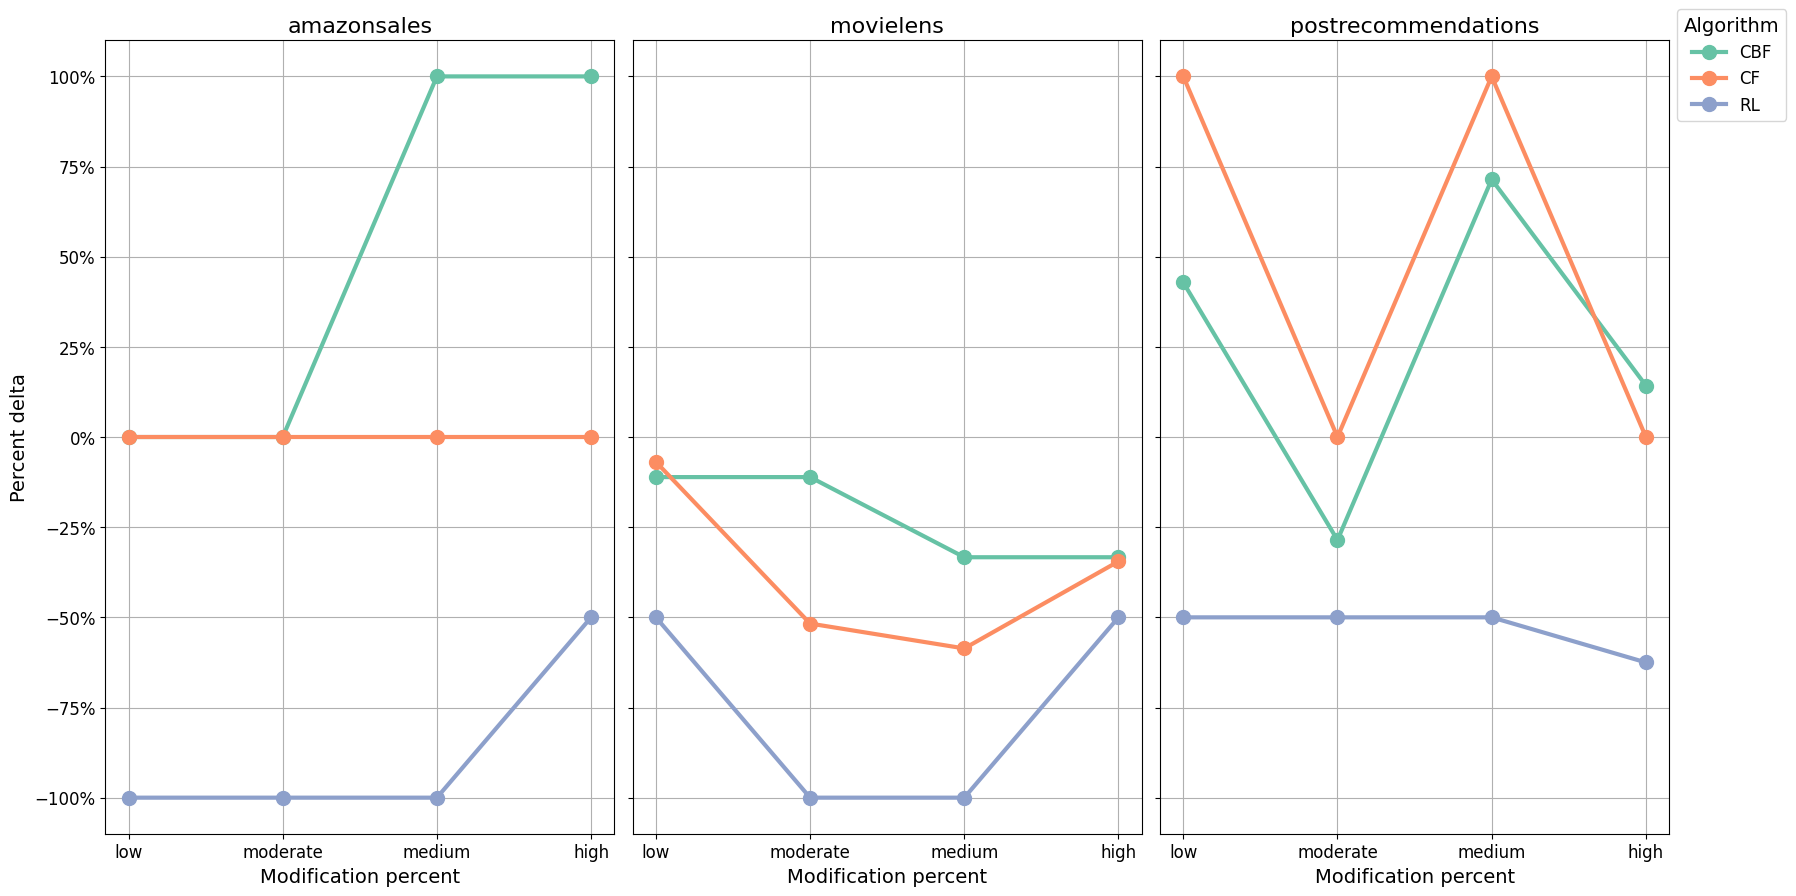

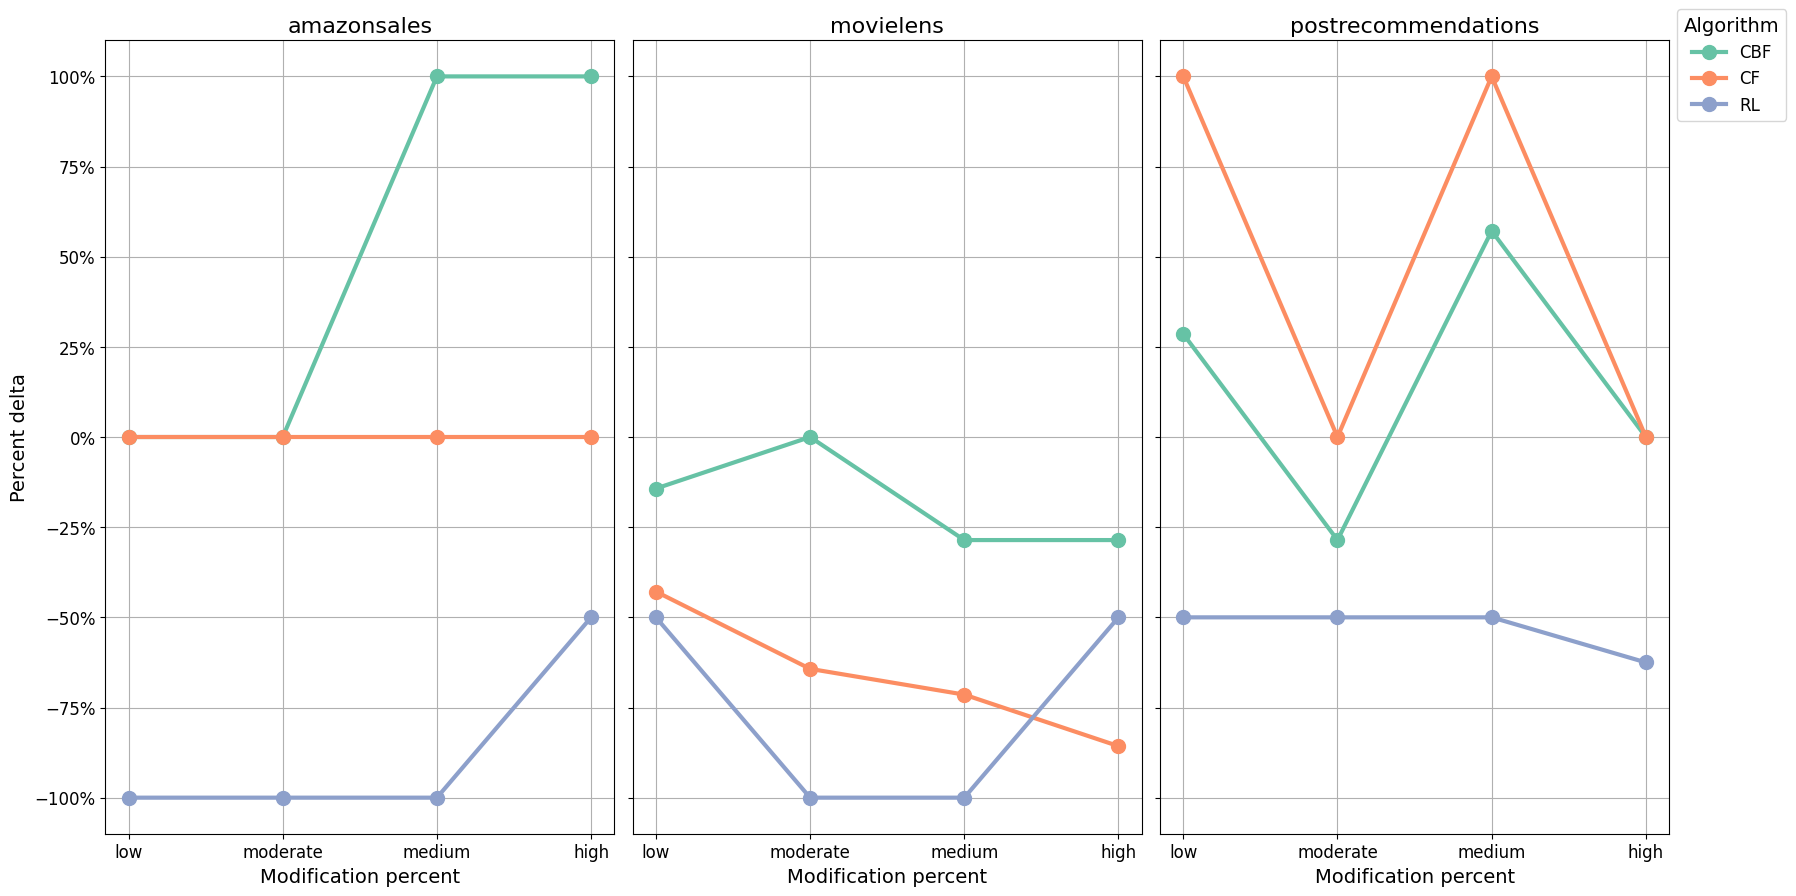

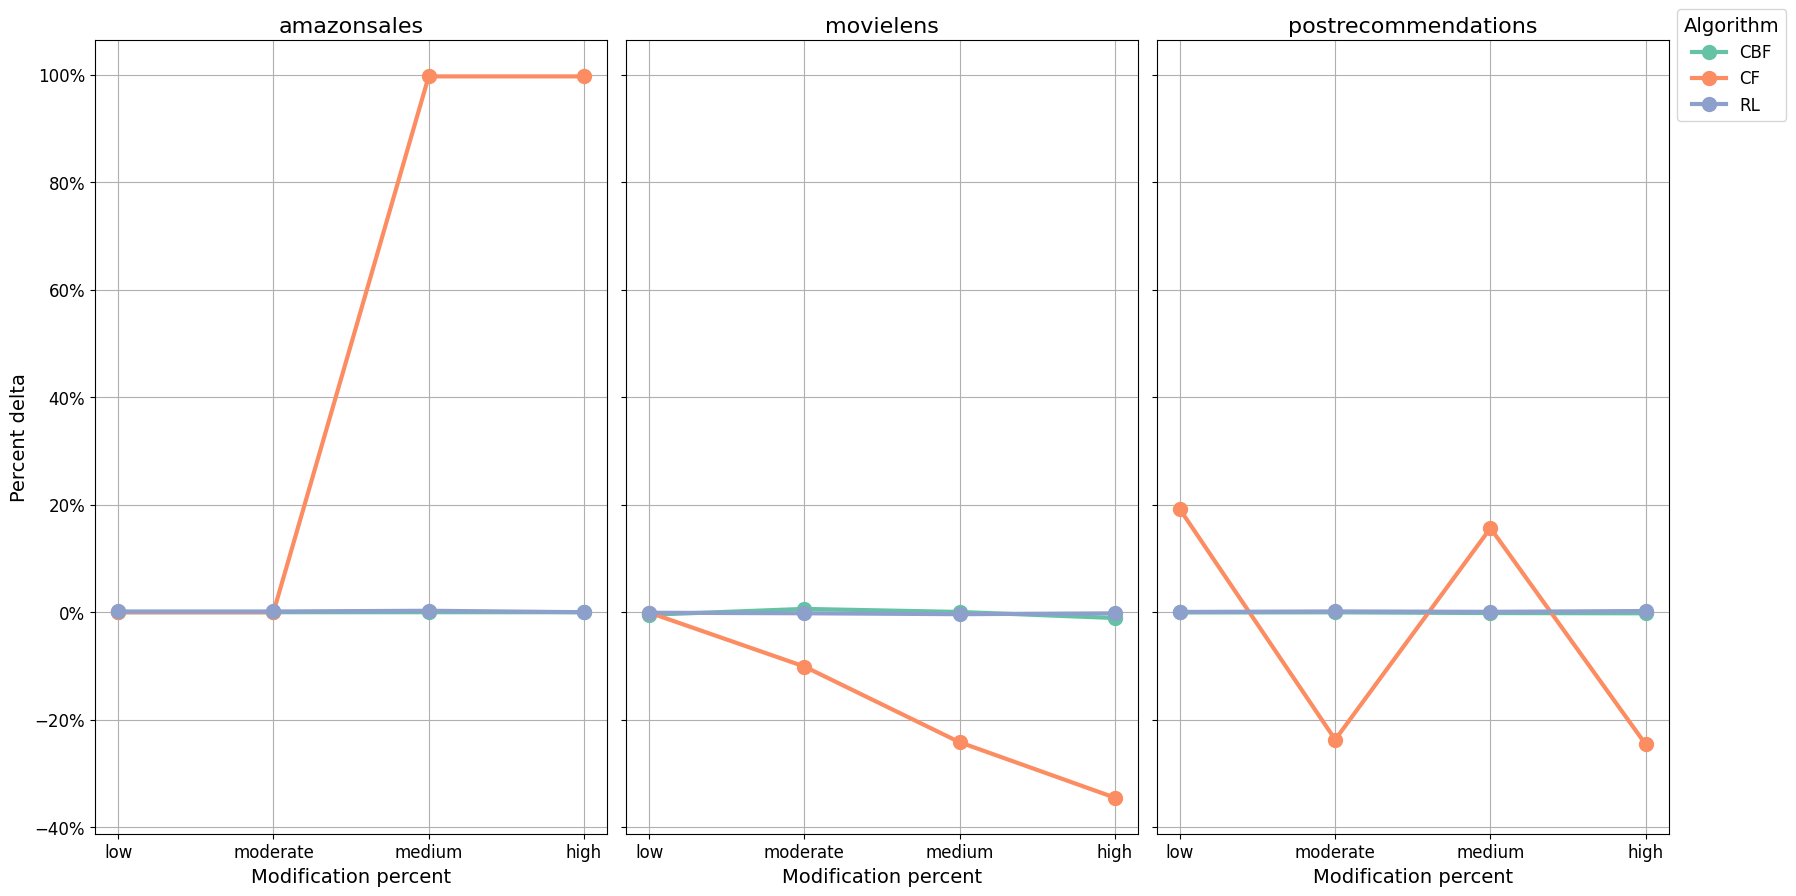

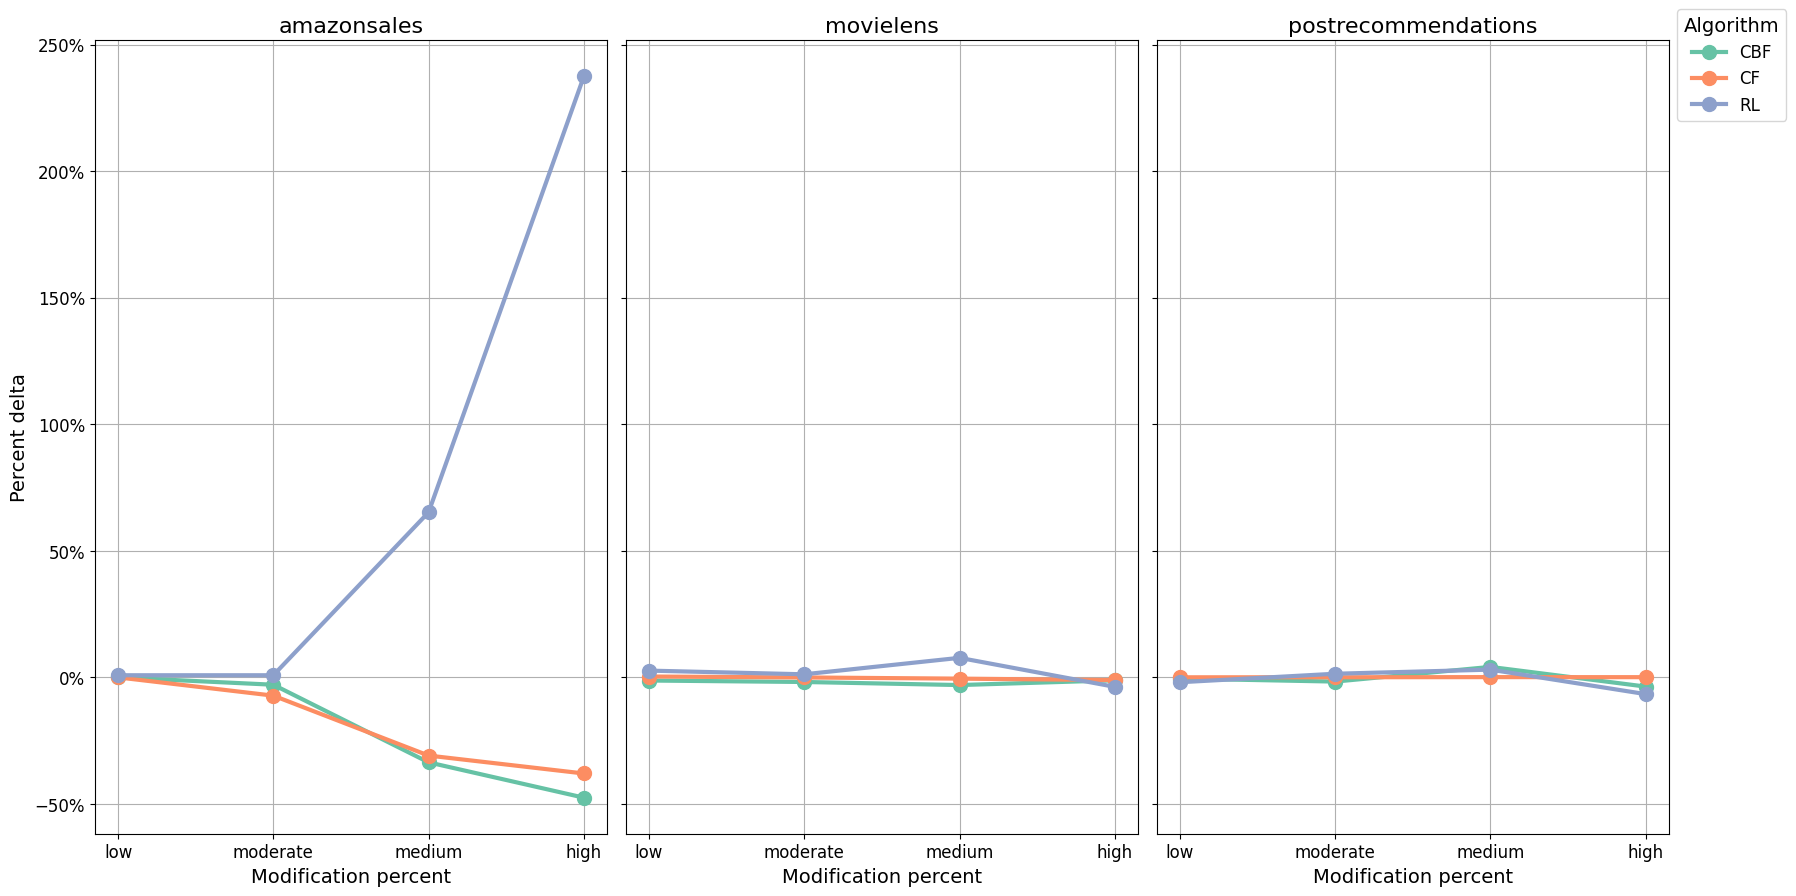

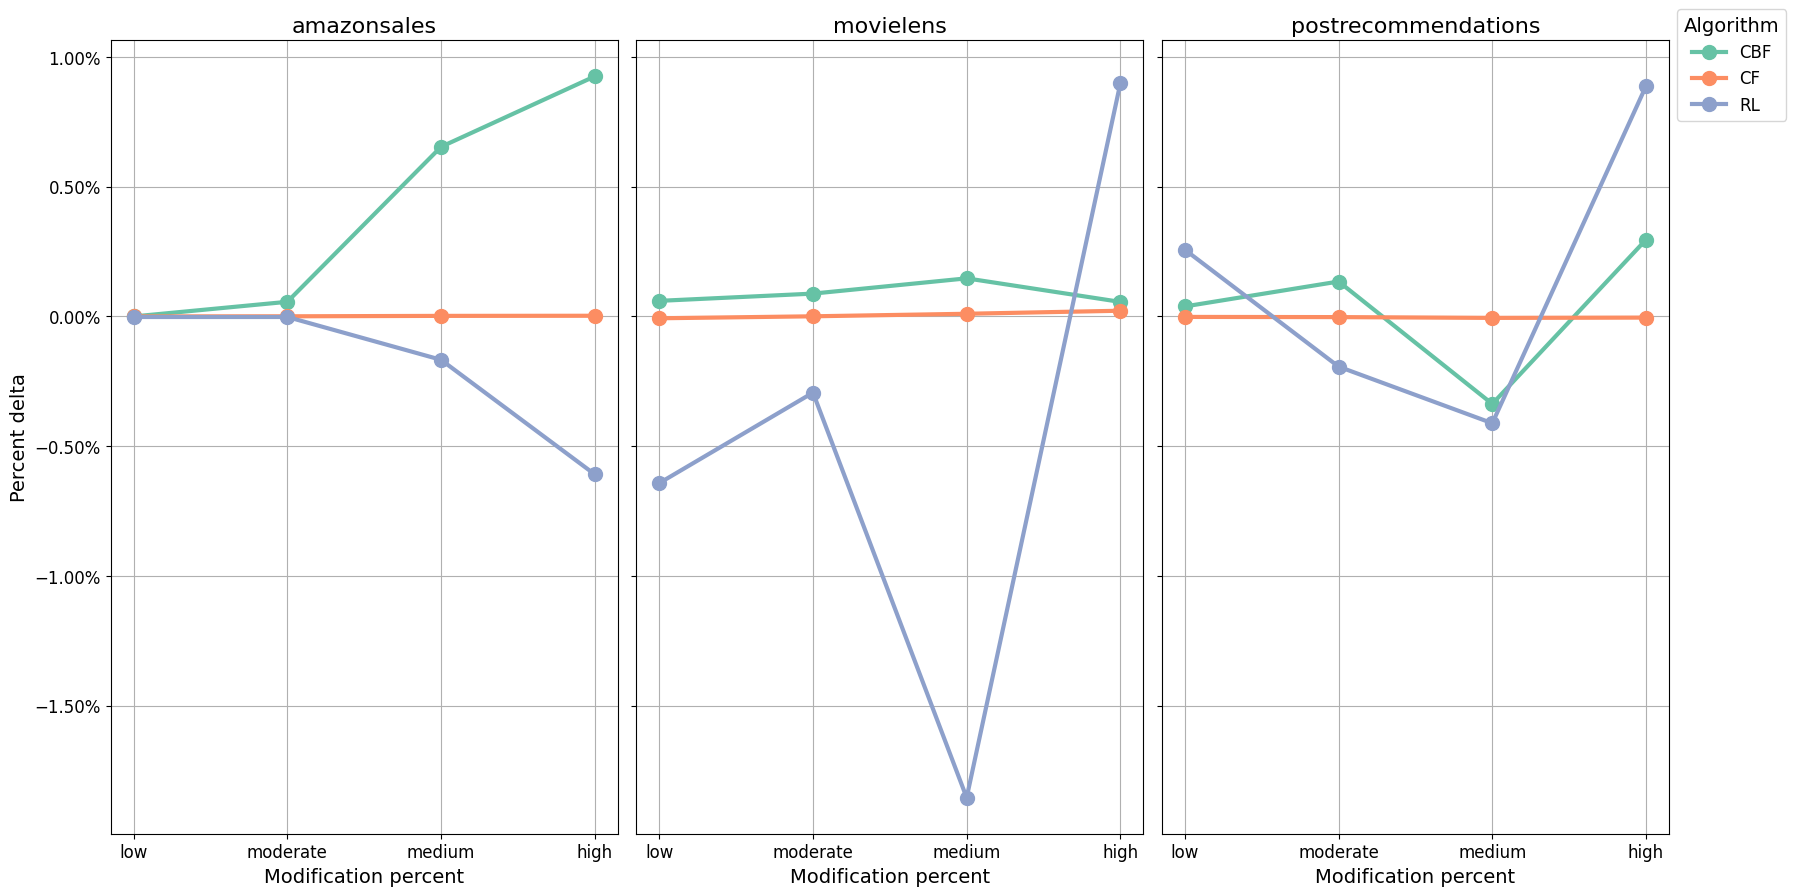

In [10]:
if specific:
    import matplotlib.pyplot as plt
    from matplotlib.ticker import PercentFormatter
    import seaborn as sns

    df = specific_df.copy()
    df['combo'] = df['algorithm'] + ' - ' + df['dataset']

    algorithms = df['algorithm'].unique()
    datasets = df['dataset'].unique()

    # Paleta Set2 z Seaborn — kolory do legendy
    palette = sns.color_palette("Set2", n_colors=len(algorithms))
    algorithm_colors = dict(zip(algorithms, palette))

    for key in df['key'].unique():
        key_subset = df[df['key'] == key]

        fig, axes = plt.subplots(1, 3, figsize=(18, 9), sharey=True)
        
        for i, dataset in enumerate(datasets):
            ax = axes[i]
            dataset_subset = key_subset[key_subset['dataset'] == dataset]

            for alg in algorithms:
                alg_subset = dataset_subset[dataset_subset['algorithm'] == alg]
                base_color = algorithm_colors[alg]

                ax.plot(
                    alg_subset['percent'],
                    alg_subset['percent_delta'],
                    marker='o',
                    label=alg,
                    color=base_color,
                    linewidth=3,    # pogrubienie linii
                    markersize=10   # powiększenie kropek
                )

            ax.set_title(f"{dataset}", fontsize=16)
            ax.set_xlabel("Modification percent", fontsize=14)
            ax.tick_params(axis='both', labelsize=12)
            ax.grid(True)
            ax.yaxis.set_major_formatter(PercentFormatter(1.0))
            if i == 0:
                ax.set_ylabel("Percent delta", fontsize=14)

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(
            handles,
            labels,
            title="Algorithm",
            title_fontsize=14,
            fontsize=12,
            bbox_to_anchor=(0.93, 1),
            loc='upper left'
        )

        plt.tight_layout()
        plt.subplots_adjust(right=0.93)
        if save:
            plt.savefig(f'{save_path}/fig/{key}.png')
        plt.show()


In [11]:
if not specific:
    metrics_to_plot = ['personalization', 'intra_list_dissimilarity']

    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df[merged_df['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )

        ax.legend_.remove()

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            height = p.get_height()
            algo = row['algorithm']
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10, color='black'
                )
        if metric == 'personalization':
            metric = 'Inter-diversity'
        elif metric == 'intra_list_dissimilarity':
            metric = 'Intra-list dissimilarity'
        ax.set_ylabel(metric)  # etykieta osi Y
        ax.set_xlabel('Dataset')  # etykieta osi X
        ax.set_ylim(0, 1)  # limit osi Y od 0 do 1
        ax.set_yticks([i/10 for i in range(11)])
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/personalization_intra_list_dissimilarity.png')
    plt.savefig(f'{folder_path}/fig/between_intra_dissimilarity.png')
    plt.show()

In [12]:
if not specific:
    metrics_to_plot = ['item_coverage', 'user_coverage']

    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df[merged_df['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )

        ax.legend_.remove()

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            height = p.get_height()
            algo = row['algorithm']
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10, color='black'
                )
        if metric == 'item_coverage':
            metric = 'Item coverage'
        elif metric == 'user_coverage':
            metric = 'User coverage'
        ax.set_ylabel(metric)  # etykieta osi Y
        ax.set_xlabel('Dataset')  # etykieta osi X
        ax.set_ylim(0, 1)  # limit osi Y od 0 do 1
        ax.set_yticks([i/10 for i in range(11)])
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/item_user_coverage.png')
    plt.show()

In [13]:
if not specific:
    metrics_to_plot = ['mae', 'rmse']

    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df[merged_df['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )

        ax.legend_.remove()

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            height = p.get_height()
            algo = row['algorithm']
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10, color='black'
                )
        if metric == 'mae':
            metric = 'MAE'
        elif metric == 'rmse':
            metric = 'RMSE'
        ax.set_ylabel(metric)  # etykieta osi Y
        ax.set_xlabel('Dataset')  # etykieta osi X
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/mae_rmse.png')
    plt.show()

In [14]:
if not specific:
    metrics_to_plot = ['mrr', 'ndcg_at_k']

    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df[merged_df['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )

        ax.legend_.remove()

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            height = p.get_height()
            algo = row['algorithm']
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10, color='black'
                )
        ax.set_ylim(0, 1)
        if metric == 'ndcg_at_k':
            metric='NDCG'
        elif metric == 'mrr':
            metric='MRR'
        ax.set_ylabel(metric)  # etykieta osi Y
        ax.set_xlabel('Dataset')  # etykieta osi X
        ax.set_ylim(0, 1)  # limit osi Y od 0 do 1
        ax.set_yticks([i/10 for i in range(11)])
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/mrr_ndcg.png')
    plt.show()

In [15]:
if not specific:
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=False)

    df_precision = merged_df[merged_df['key'] == 'precision']
    df_precision_at_k = merged_df[merged_df['key'] == 'precision_at_k']

    ax = axes[0]
    sns.barplot(
        data=df_precision,
        x='dataset',
        y='value',
        hue='algorithm',
        palette='Set2',
        ax=ax
    )
    ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    bar_colors = [patch.get_facecolor() for patch in handles]
    algo_colors = dict(zip(labels, bar_colors))

    for p, (_, row) in zip(ax.patches, df_precision_at_k.iterrows()):
        height = p.get_height()
        algo = row['algorithm']
        if not pd.isna(height):
            base_color = algo_colors.get(algo, (0.5, 0.5, 0.5, 1.0))
            lighter_color = mcolors.to_rgba(base_color)
            lighter_rgb = mcolors.to_rgb(lighter_color[:3])
            lighter_rgb = mcolors.to_rgba([min(1, c + 0.4*(1-c)) for c in lighter_rgb])

            ax.bar(
                p.get_x() + p.get_width() / 2,
                row['value'] - height,
                width=p.get_width(),
                bottom=height,
                align='center',
                color=lighter_rgb,
                edgecolor='none'
            )
            ax.annotate(
                algo,
                (p.get_x() + p.get_width() / 2, row['value']),
                ha='center', va='bottom',
                fontsize=10, color='black'
            )
    ax.set_ylabel('Precision')
    ax.set_xlabel('Dataset')
    ax.set_ylim(0, 1)
    ax.set_yticks([i/10 for i in range(11)])
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    # Recall plot
    df_recall = merged_df[merged_df['key'] == 'recall']
    df_recall_at_k = merged_df[merged_df['key'] == 'recall_at_k']

    ax = axes[1]
    sns.barplot(
        data=df_recall,
        x='dataset',
        y='value',
        hue='algorithm',
        palette='Set2',
        ax=ax
    )
    ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    bar_colors = [patch.get_facecolor() for patch in handles]
    algo_colors = dict(zip(labels, bar_colors))

    for p, (_, row) in zip(ax.patches, df_recall_at_k.iterrows()):
        height = p.get_height()
        algo = row['algorithm']
        if not pd.isna(height):
            base_color = algo_colors.get(algo, (0.5, 0.5, 0.5, 1.0))
            lighter_color = mcolors.to_rgba(base_color)
            lighter_rgb = mcolors.to_rgb(lighter_color[:3])
            lighter_rgb = mcolors.to_rgba([min(1, c + 0.4*(1-c)) for c in lighter_rgb])

            ax.bar(
                p.get_x() + p.get_width() / 2,
                row['value'] - height,
                width=p.get_width(),
                bottom=height,
                align='center',
                color=lighter_rgb,
                edgecolor='none'
            )
            ax.annotate(
                algo,
                (p.get_x() + p.get_width() / 2, row['value']),
                ha='center', va='bottom',
                fontsize=10, color='black'
            )
    ax.set_ylabel('Recall')
    ax.set_xlabel('Dataset')
    ax.set_ylim(0, 1)
    ax.set_yticks([i/10 for i in range(11)])
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/precision_recall.png')
    plt.show()